In [1]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import util

In [2]:
RAM_REF_MAPPIGN = "/storage2/tbrekalo/HG002-simulated/chr19-sample-ram-ref.paf"
TB_RAM_REF_MAPPIGN = "/storage2/tbrekalo/HG002-simulated/chr19-sample-tb-ram-ref.paf"
TB_RAM_AI_REF_MAPPIGN = "/storage2/tbrekalo/HG002-simulated/chr19-sample-tb-ram-ai-ref.tsv"
MINIMAP2_REF_MAPPIGN = "/storage2/tbrekalo/HG002-simulated/chr19-ovlps-minimap2-ref.paf"
READ_ORIGINS = "/storage2/tbrekalo/HG002-simulated/chr19-read-origins.csv"

In [3]:
df_origins = util.load_origins_df(READ_ORIGINS)
MIN_RATIO=0.875

In [4]:
def create_df_ai_ram(
    input_path: pl.DataFrame, df_origins: pl.DataFrame
) -> pl.DataFrame:
    return (
        util.create_annotated_ref_overlaps(
            pl.read_csv(
                input_path,
                has_header=False,
                new_columns=util.RAM_OVERLAP_AI_COLUMNS,
                separator="\t",
            ),
            df_origins,
        )
        .select(
            *util.RAM_OVERLAP_AI_COLUMNS,
            pl.col("ratio"),
            (pl.col("ratio") > MIN_RATIO).cast(pl.Int64).alias("label"),
        )
        .with_columns(
            pl.when(pl.col("strand") == "+")
            .then(pl.lit(1))
            .otherwise(pl.lit(0))
            .alias("strand"),
            pl.min_horizontal(
                pl.col("query-matches"),
                pl.col("target-matches"),
            ).alias("n-residue-matches"),
        )
    )


df_tb_ram_ai = create_df_ai_ram(TB_RAM_AI_REF_MAPPIGN, df_origins)

In [5]:
def load_ref_df(path: str, df_origins: pl.DataFrame, min_ratio: float) -> pl.DataFrame:
    return (
        util.create_annotated_ref_overlaps(
            util.load_paf_df(path),
            df_origins,
        )
        .with_columns(
            pl.when(pl.col("strand") == "+").then(pl.lit(1)).otherwise(pl.lit(0)).alias("strand")
        )
        .drop("origin-start", "origin-end", "origin-strand")
        .with_columns((pl.col("ratio") > min_ratio).alias("label").cast(pl.Int64))
    )

In [6]:
df_minimap2 = load_ref_df(MINIMAP2_REF_MAPPIGN, df_origins, MIN_RATIO)
# df_tb_ram = load_ref_df(TB_RAM_REF_MAPPIGN, df_origins, MIN_RATIO)
df_ram = load_ref_df(RAM_REF_MAPPIGN, df_origins, MIN_RATIO)

In [7]:
print(f'minimap2: {df_minimap2.select(pl.col("label").value_counts())}')
print(f'ram: {df_ram.select(pl.col("label").value_counts())}')
print(f'tb-ram: {df_tb_ram_ai.select(pl.col("label").value_counts())}')

minimap2: shape: (2, 1)
┌────────────┐
│ label      │
│ ---        │
│ struct[2]  │
╞════════════╡
│ {0,16031}  │
│ {1,106233} │
└────────────┘
ram: shape: (2, 1)
┌────────────┐
│ label      │
│ ---        │
│ struct[2]  │
╞════════════╡
│ {1,1112}   │
│ {0,173187} │
└────────────┘
tb-ram: shape: (2, 1)
┌───────────┐
│ label     │
│ ---       │
│ struct[2] │
╞═══════════╡
│ {1,1053}  │
│ {0,22947} │
└───────────┘


In [8]:
dfs = {
    "minimap2": df_minimap2,
    # "tb-ram": df_tb_ram,
    "tb-ram-ai": df_tb_ram_ai.select(*util.PAF_COLUMNS, "label"),
    "ram": df_ram,
}


def overlap_metrics(df_in: pl.DataFrame, source: str) -> pl.DataFrame:
    return df_in.select(*util.PAF_COLUMNS, "label").with_columns(
        pl.max_horizontal(
            (pl.col("query-end") - pl.col("query-start")),
            (pl.col("target-end") - pl.col("target-start")),
        ).alias("overlap-length"),
        pl.lit(source).alias("source"),
    )


df_overlaps = pl.concat([
    overlap_metrics(df, source) for source, df in dfs.items()
])

In [9]:
df_overlaps.group_by("source", "label").agg(
    pl.struct(["query-name", "target-name"]).n_unique().alias("n-unique-pairs"),
    pl.col("overlap-length").mean().alias("overlap-length-mean"),
    pl.col("overlap-length").std().alias("overlap-length-std"),
    pl.col("overlap-length").quantile(0.25).alias("overlap-length-q25"),
    pl.col("overlap-length").median().alias("overlap-length-median"),
    pl.col("overlap-length").quantile(0.75).alias("overlap-length-q75"),
).sort(by=["source", "label"])

source,label,n-unique-pairs,overlap-length-mean,overlap-length-std,overlap-length-q25,overlap-length-median,overlap-length-q75
str,i64,u32,f64,f64,f64,f64,f64
"""minimap2""",0,3937,18324.846235,3325.132637,16992.0,18353.0,19889.0
"""minimap2""",1,106056,18478.222106,2146.304638,17101.0,18333.0,19721.0
"""ram""",0,1093,3821.382269,5047.826996,891.0,1792.0,4643.0
"""ram""",1,1097,18618.918165,1974.247753,17253.0,18452.0,19801.0
"""tb-ram-ai""",0,960,1119.528261,1644.935872,348.0,630.0,1192.0
"""tb-ram-ai""",1,1053,18570.34188,1989.579813,17201.0,18417.0,19770.0


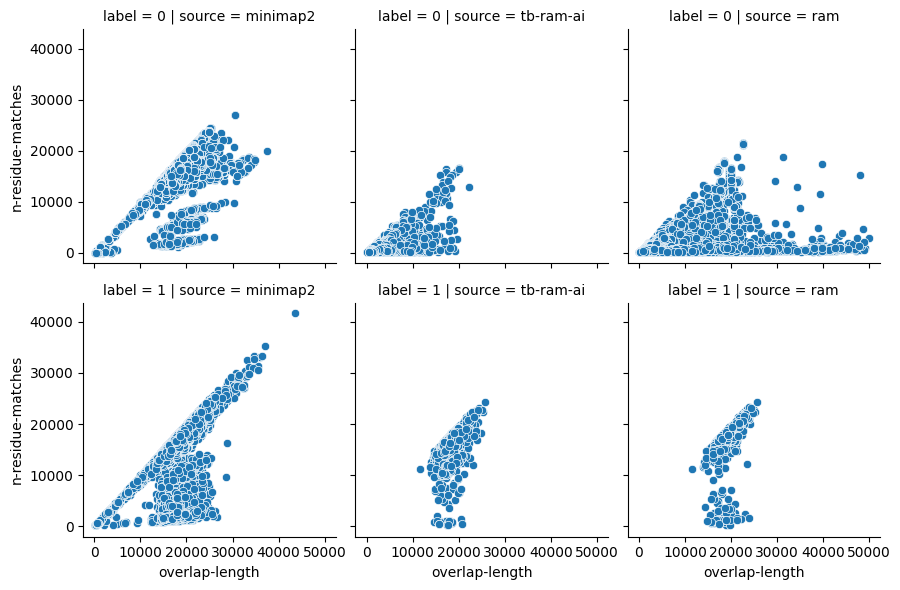

In [10]:
g = sns.FacetGrid(
    df_overlaps.filter(pl.col("overlap-length") < 50_000).to_pandas(),
    row="label",
    col="source",
)
g.map_dataframe(sns.scatterplot, x="overlap-length", y="n-residue-matches")